In [1]:
ultrasound_size = 128

data_folder = r"SagittalSpineSegmentationArrays"

ultrasound_file = r"ultrasound.npy"
segmentation_file = r"segmentation.npy"

test_ultrasound_file = r"ultrasound-test.npy"
test_segmentation_file = r"segmentation-test.npy"

In [2]:
import datetime
import numpy as np
import os 

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator

from local_vars import root_folder

Using TensorFlow backend.


In [3]:
data_fullpath = os.path.join(root_folder, data_folder)

ultrasound_fullname = os.path.join(data_fullpath, ultrasound_file)
segmentation_fullname = os.path.join(data_fullpath, segmentation_file)

print("Reading ultrasound images from:  {}".format(ultrasound_fullname))
print("Reading segmentations from:      {}".format(segmentation_fullname))

ultrasound_data = np.load(ultrasound_fullname)
segmentation_data = np.load(segmentation_fullname)

num_ultrasound = ultrasound_data.shape[0]
num_segmentation = segmentation_data.shape[0]

print("\nFound {} ultrasound images and {} segmentations".format(num_ultrasound, num_segmentation))

Reading ultrasound images from:  j:\Data\SagittalSpineSegmentationArrays\ultrasound.npy
Reading segmentations from:      j:\Data\SagittalSpineSegmentationArrays\segmentation.npy

Found 715 ultrasound images and 715 segmentations


In [4]:
test_ultrasound_fullname = os.path.join(data_fullpath, test_ultrasound_file)
test_segmentation_fullname = os.path.join(data_fullpath, test_segmentation_file)

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname)
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))

Reading test ultrasound from: j:\Data\SagittalSpineSegmentationArrays\ultrasound-test.npy
Reading test segmentation from : j:\Data\SagittalSpineSegmentationArrays\segmentation-test.npy

Found 80 test ultrasound images and 80 segmentations


In [5]:
import keras.utils
import scipy.ndimage

max_rotation_angle = 10

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(ultrasound_size, ultrasound_size),
                 shuffle=True,
                 n_channels=1,
                 n_classes=2):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    
    def __len__(self):
        return int(np.floor(self.number_of_images / self.batch_size))
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size, *self.image_dimensions))
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            if flip_flag == 1:
                x[i,:,:,:] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                y[i,:,:] = np.flip(self.y[batch_indexes[i],:,:], axis=1)
            else:
                x[i,:,:,:] = self.x[batch_indexes[i],:,:,:]
                y[i,:,:] = self.y[batch_indexes[i],:,:]
        
        angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (1,2), False, mode="constant", cval=0, order=0)
        y_rot = scipy.ndimage.interpolation.rotate(y, angle, (1,2), False, mode="constant", cval=0, order=0)
        
        x_rot = np.clip(x_rot, 0.0, 1.0)
        y_rot = np.clip(y_rot, 0.0, 1.0)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)
        return x_rot, y_onehot

In [6]:
num_models = 1
num_classes = 2

def nvidia_unet(patch_size=ultrasound_size, num_classes=num_classes):
    input_ = Input((patch_size, patch_size, 1))
    skips = []
    output = input_
    c = num_classes
    
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [c*8, c*16, c*32, c*32, c*32, c*32, c*32]):
        skips.append(output)
        output= Conv2D(filters, (shape, shape), strides=2, padding="same", activation="relu")(output)
    
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [c*32, c*32, c*32, c*32, c*16, c*8, c]):
        output = keras.layers.UpSampling2D()(output)
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        if filters != c:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv2D(c, (shape, shape), activation=activation, padding="same")(output)
        if filters != c:
            output = BatchNormalization(momentum=.9)(output)
    
    assert len(skips) == 0
    return Model([input_], [output])

models = [nvidia_unet(ultrasound_size, num_classes) for _ in range(num_models)]

[model.compile(optimizer=keras.optimizers.adam(), loss= "binary_crossentropy", metrics=["accuracy"]) for model in models]

# models[0].summary()

Instructions for updating:
Colocations handled automatically by placer.


[None]

In [7]:
# Prepare dilated output

def dialateStack(segmentation_data, iterations):
    return np.array([scipy.ndimage.binary_dilation(y, iterations=iterations) for y in segmentation_data])

width = 1
segmentation_dilated = dialateStack(segmentation_data[:, :, :, 0], width)

In [8]:
# Testing batch generator

batch_size = 4
num_show = 2

tgen = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_dilated, batch_size, shuffle=False)

bx, by = tgen.__getitem__(0)

import matplotlib.pyplot as plt

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    a1 = fig.add_subplot(num_show,3,i*3+1)
    img1 = a1.imshow(bx[i, :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Ultrasound #{}".format(i))
    c = fig.colorbar(img1)
    a2 = fig.add_subplot(num_show,3,i*3+2)
    img2 = a2.imshow(by[i, :, :, 0], vmin=0.0, vmax=1.0)
    a2.set_title("Class 0 #{}".format(i))
    c = fig.colorbar(img2)
    a3 = fig.add_subplot(num_show,3,i*3+3)
    img3 = a3.imshow(by[i, :, :, 1], vmin=0.0, vmax=1.0)
    a3.set_title("Class 1 #{}".format(i))
    c = fig.colorbar(img3)

In [9]:
batch_size = 10
num_epochs = 100

training_generator = UltrasoundSegmentationBatchGenerator(ultrasound_data, segmentation_dilated, batch_size)
test_generator = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data[:, :, :, 0], batch_size)

training_time_start = datetime.datetime.now()

training_log = models[0].fit_generator(training_generator,
                                       validation_data=test_generator,
                                       epochs=num_epochs,
                                       verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/100
71/71 [==============================] - 4s 57ms/step - loss: 0.3727 - acc: 0.9726 - val_loss: 0.2233 - val_acc: 0.9962
Epoch 2/100
71/71 [==============================] - 1s 21ms/step - loss: 0.1564 - acc: 0.9936 - val_loss: 0.0715 - val_acc: 0.9969
Epoch 3/100
71/71 [==============================] - 2s 23ms/step - loss: 0.0660 - acc: 0.9939 - val_loss: 0.0350 - val_acc: 0.9971
Epoch 4/100
71/71 [==============================] - 2s 23ms/step - loss: 0.0376 - acc: 0.9940 - val_loss: 0.0233 - val_acc: 0.9968
Epoch 5/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0281 - acc: 0.9940 - val_loss: 0.0204 - val_acc: 0.9959
Epoch 6/100
71/71 [==============================] - 2s 23ms/step - loss: 0.0239 - acc: 0.9940 - val_loss: 0.0201 - val_acc: 0.9948
Epoch 7/100
71/71 [==============================] - 2s 23ms/step - loss: 0.0215 -

Epoch 59/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0139 - acc: 0.9950 - val_loss: 0.0089 - val_acc: 0.9966
Epoch 60/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0137 - acc: 0.9950 - val_loss: 0.0127 - val_acc: 0.9954
Epoch 61/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0137 - acc: 0.9951 - val_loss: 0.0142 - val_acc: 0.9946
Epoch 62/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0138 - acc: 0.9951 - val_loss: 0.0094 - val_acc: 0.9964
Epoch 63/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0136 - acc: 0.9951 - val_loss: 0.0100 - val_acc: 0.9961
Epoch 64/100
71/71 [==============================] - 2s 22ms/step - loss: 0.0136 - acc: 0.9951 - val_loss: 0.0093 - val_acc: 0.9965
Epoch 65/100
71/71 [==============================] - 2s 23ms/step - loss: 0.0135 - acc: 0.9952 - val_loss: 0.0147 - val_acc: 0.9944
Epoch 66/100
71/71 [==============================] - 2s 22ms/step - 

In [10]:
training_time_stop = datetime.datetime.now()
print("Training started at: {}".format(training_time_start))
print("Training stopped at: {}".format(training_time_stop))
print("Total training time: {}".format(training_time_stop-training_time_start))

Training started at: 2019-05-31 00:28:34.536350
Training stopped at: 2019-05-31 00:31:16.914958
Total training time: 0:02:42.378608


In [11]:
y_pred = models[0].predict(test_ultrasound_data)

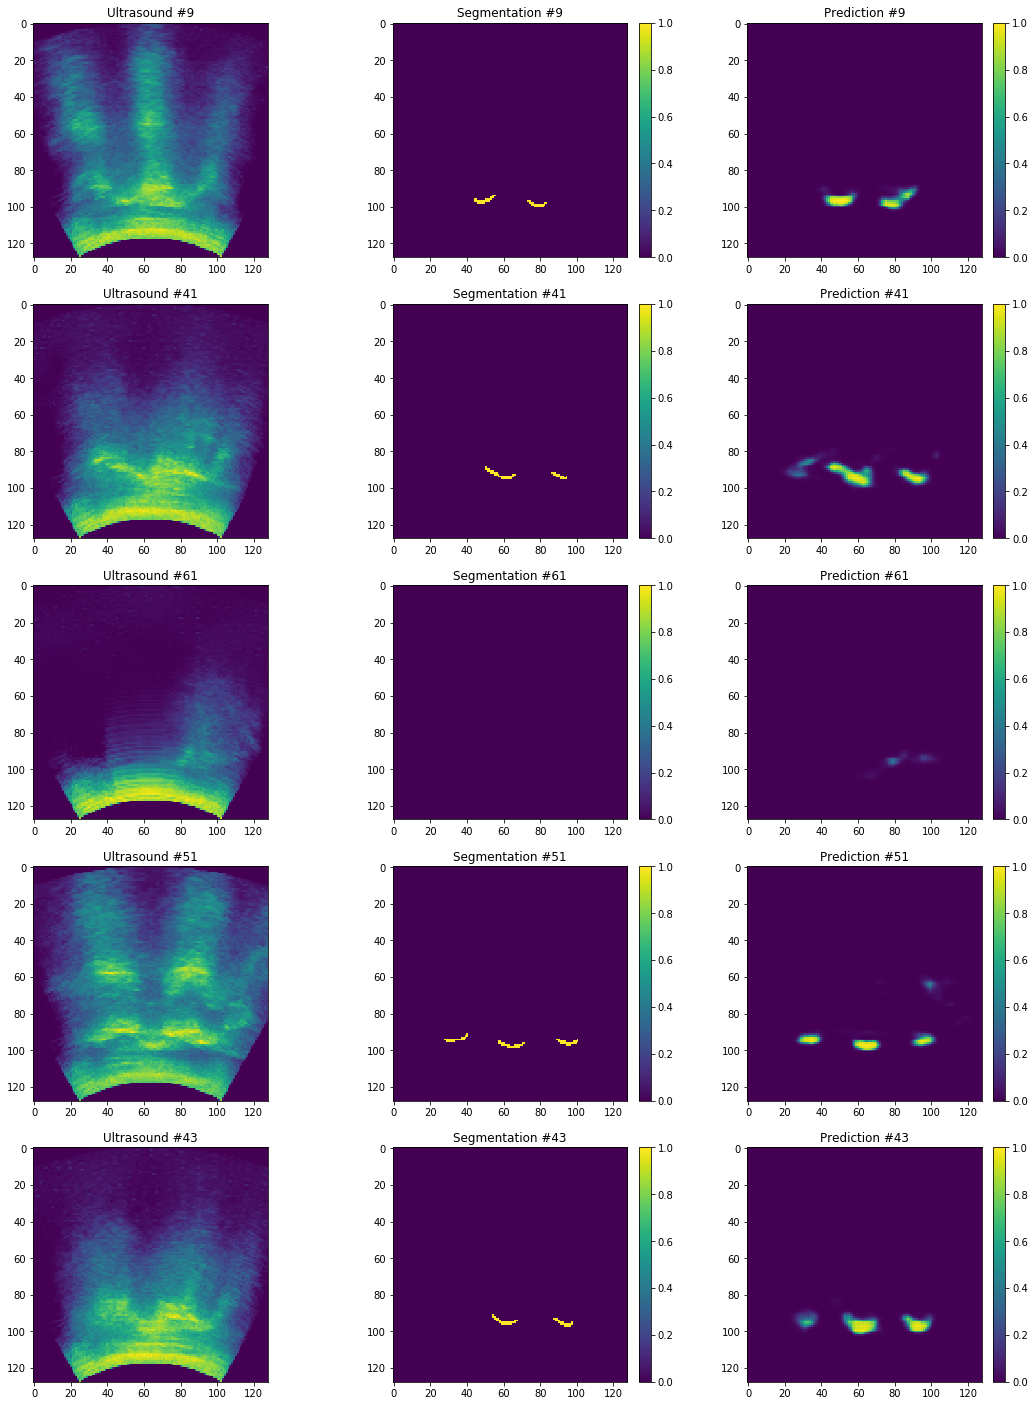

In [12]:
from random import sample

num_test = test_ultrasound_data.shape[0]
num_show = 5

indices = [i for i in range(num_test)]
sample_indices = sample(indices, num_show)

fig = plt.figure(figsize=(18, num_show*5))
for i in range(num_show):
    a0 = fig.add_subplot(num_show,3,i*3+1)
    img0 = a0.imshow(test_ultrasound_data[sample_indices[i], :, :, 0].astype(np.float32))
    a0.set_title("Ultrasound #{}".format(sample_indices[i]))
    a1 = fig.add_subplot(num_show,3,i*3+2)
    img1 = a1.imshow(test_segmentation_data[sample_indices[i], :, :, 0], vmin=0.0, vmax=1.0)
    a1.set_title("Segmentation #{}".format(sample_indices[i]))
    c = fig.colorbar(img1, fraction=0.046, pad=0.04)
    a2 = fig.add_subplot(num_show,3,i*3+3)
    img2 = a2.imshow(y_pred[sample_indices[i], :, :, 1], vmin=0.0, vmax=1.0)
    a2.set_title("Prediction #{}".format(sample_indices[i]))
    c = fig.colorbar(img2, fraction=0.046, pad=0.04)

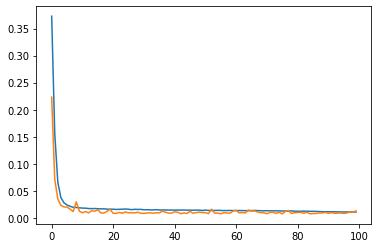

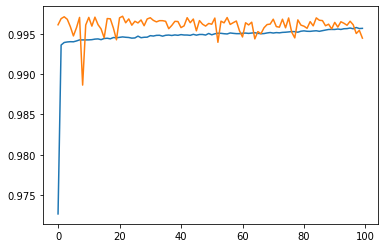

In [13]:
plt.plot(training_log.history['loss'])
plt.plot(training_log.history['val_loss'])
plt.show()
plt.plot(training_log.history['acc'])
plt.plot(training_log.history['val_acc'])
plt.show()

In [14]:
import datetime

timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

saved_models_folder = os.path.join(root_folder, "saved_models")

if not os.path.exists(saved_models_folder):
    os.makedirs(saved_models_folder)
    print("Creating folder: {}".format(saved_models_folder))

model_file_name = "model_" + timestamp + ".h5"
weights_file_path = os.path.join(saved_models_folder, model_file_name)

models[0].save(weights_file_path)

print("Model saved to: {}".format(weights_file_path))

Model saved to: j:\Data\saved_models\model_2019-05-31_00-31-20.h5
